In [ ]:
%tensorflow_version 1.x

!pip install transformers


     |████████████████████████████████| 2.1MB 5.0MB/s 
     |████████████████████████████████| 870kB 17.7MB/s 
     |████████████████████████████████| 3.3MB 22.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=82fbfbb1a326f5e47fab30b79f06076b98c7689918132c8993726e34216d5dd4
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np
#np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
#from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf

import tensorflow_hub as hub

Using TensorFlow backend.


In [ ]:
from google.colab import files
uploaded = files.upload()



Saving BBC News Train.csv to BBC News Train.csv


In [ ]:
import io
train_raw = pd.read_csv(io.BytesIO(uploaded['BBC News Train.csv']))
train_raw.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


business
entertainment
politics
sport
tech


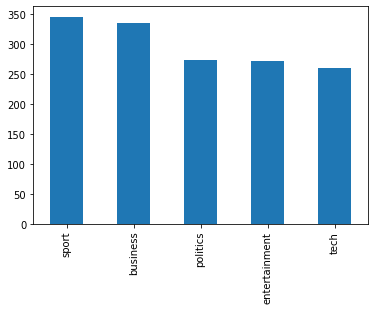

In [ ]:


"""train_raw.Text.apply(lambda x: len(x.split())).plot(kind='hist')

train_raw.describe()"""


train_raw = train_raw[['Text', 'Category']]
#train_raw.reset_index(inplace=True, drop=True)
#train_raw.head()


for l in np.unique(train_raw['Category']):
  print(l)
  
train_raw['Category'].value_counts().sort_values(ascending=False).plot(kind='bar')


train_raw=train_raw.rename(columns = {'Text':'text', 'Category':'label'})
train_raw.head()

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

train = train_raw.copy()

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.3)
train.head()

train.reset_index(drop=True, inplace=True)
train.head()

val.reset_index(drop=True, inplace=True)
val.head()




,text,label
0,top of the pops leaves bbc one the bbc s flags...,1
1,more power to the people says hp the digital r...,4
2,record year for chilean copper chile s copper ...,0
3,sideways dominates spirit awards the comedy si...,1
4,tevez - an argentine in brazil some 65 years a...,3


In [ ]:

from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')

for i in train['text']:
  x = generator(i, max_length = 1000, num_return_sequences=1)
  train['text'][i]= x[0]['generated_text']

Token indices sequence length is longer than the specified maximum sequence length for this model (1137 > 1024). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1137, but ``max_length`` is set to 1000.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 1135, but ``max_length`` is set to 1000.This can lead to unexpected behavior. You should consider increa

In [ ]:

import re
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)    
  return text


train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
0,gb select holmes for double bid kelly holmes h...,3
1,china continues rapid growth china s economy h...,0
2,giving financial gifts to children your child ...,0
3,us prepares for hybrid onslaught sales of hybr...,0
4,wales stars need a rest ruddock wales coach mi...,3


In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.3)
train.head()

train.reset_index(drop=True, inplace=True)
train.head()

val.reset_index(drop=True, inplace=True)
val.head()




,text,label
0,could rivalry overshadow election tony blair a...,2
1,holmes is hit by hamstring injury kelly holmes...,3
2,labour faces cold calls inquiry labour is to b...,2
3,clijsters hope on aussie open kim clijsters ha...,3
4,ebbers denies worldcom fraud former worldcom c...,0


In [ ]:
pip install bert-tensorflow==1.0.1

     |████████████████████████████████| 71kB 2.6MB/s 


In [ ]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [ ]:
OUTPUT_DIR = '/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

In [ ]:

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

***** Model output directory: /bert_news_category *****
Training Set Shape : (730, 2)
Validation Set Shape : (313, 2)


[0, 1, 2, 3, 4]

In [ ]:


def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total



In [ ]:


train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)


train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)


(1550, 1550, 1550)

In [ ]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)



train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,could rivalry overshadow election tony blair a...,2
1,new year at westminster a behind closed doors ...,2
2,westminster actually believe that simply becau...,2
3,trouble is both men have fallen short of offer...,2
4,and deliberately provocative manner then there...,2


In [ ]:

train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

print(train_InputExamples)

0       <bert.run_classifier.InputExample object at 0x...
1       <bert.run_classifier.InputExample object at 0x...
2       <bert.run_classifier.InputExample object at 0x...
3       <bert.run_classifier.InputExample object at 0x...
4       <bert.run_classifier.InputExample object at 0x...
                              ...                        
1545    <bert.run_classifier.InputExample object at 0x...
1546    <bert.run_classifier.InputExample object at 0x...
1547    <bert.run_classifier.InputExample object at 0x...
1548    <bert.run_classifier.InputExample object at 0x...
1549    <bert.run_classifier.InputExample object at 0x...
Length: 1550, dtype: object


In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  call to save manufacturing jobs the trades union congress tuc is calling on the government to stem job losses in manufacturing firms by reviewing the help it gives companies the tuc said in its submission before the budget that action is needed because of 105 000 jobs lost from the sector over the last year it calls for better pensions child care provision and decent wages the 36 page submission also urges the government to examine support other european countries provide to industry tuc general secretary brendan barber called for a commitment to policies that will make a real difference to the lives of working people greater investment in childcare strategies and the people delivering that childcare will increases the options available to working parents he said a commitment to our public services and manufacturing sector ensures that we can continue to compete on a global level and deliver the frontlin

In [ ]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'.
INFO:absl:Downloaded https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1, Total size: 421.86MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
len(tokenizer.vocab.keys())

30522

In [ ]:
MAX_SEQ_LENGTH = 200

In [ ]:
#Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 1550


INFO:tensorflow:Writing example 0 of 1550


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] call to save manufacturing jobs the trades union congress tu ##c is calling on the government to stem job losses in manufacturing firms by reviewing the help it gives companies the tu ##c said in its submission before the budget that action is needed because of 105 000 jobs lost from the sector over the last year it calls for better pensions child care provision and decent wages the 36 page submission also urges the government to examine support other european countries provide to industry tu ##c general secretary brendan barber called for a commitment to policies that will make a real difference to the lives of working people greater investment in child ##care strategies and the people delivering that child ##care will increases the options available to working parents he said a commitment to our public services and manufacturing sector ensures that we can continue to compete on a global level and deliver the front ##line services that this country needs 

INFO:tensorflow:tokens: [CLS] call to save manufacturing jobs the trades union congress tu ##c is calling on the government to stem job losses in manufacturing firms by reviewing the help it gives companies the tu ##c said in its submission before the budget that action is needed because of 105 000 jobs lost from the sector over the last year it calls for better pensions child care provision and decent wages the 36 page submission also urges the government to examine support other european countries provide to industry tu ##c general secretary brendan barber called for a commitment to policies that will make a real difference to the lives of working people greater investment in child ##care strategies and the people delivering that child ##care will increases the options available to working parents he said a commitment to our public services and manufacturing sector ensures that we can continue to compete on a global level and deliver the front ##line services that this country needs 

INFO:tensorflow:input_ids: 101 2655 2000 3828 5814 5841 1996 14279 2586 3519 10722 2278 2003 4214 2006 1996 2231 2000 7872 3105 6409 1999 5814 9786 2011 15252 1996 2393 2009 3957 3316 1996 10722 2278 2056 1999 2049 12339 2077 1996 5166 2008 2895 2003 2734 2138 1997 8746 2199 5841 2439 2013 1996 4753 2058 1996 2197 2095 2009 4455 2005 2488 22024 2775 2729 9347 1998 11519 12678 1996 4029 3931 12339 2036 23876 1996 2231 2000 11628 2490 2060 2647 3032 3073 2000 3068 10722 2278 2236 3187 15039 13362 2170 2005 1037 8426 2000 6043 2008 2097 2191 1037 2613 4489 2000 1996 3268 1997 2551 2111 3618 5211 1999 2775 16302 9942 1998 1996 2111 12771 2008 2775 16302 2097 7457 1996 7047 2800 2000 2551 3008 2002 2056 1037 8426 2000 2256 2270 2578 1998 5814 4753 21312 2008 2057 2064 3613 2000 5566 2006 1037 3795 2504 1998 8116 1996 2392 4179 2578 2008 2023 2406 3791 2002 2036 2170 2005 6742 5761 2000 2393 11550 2545 2926 2308 2040 2002 2056 2024 2087 3497 2000 11036 1999 5635 1996 12339 2036 4455 2005 115

INFO:tensorflow:input_ids: 101 2655 2000 3828 5814 5841 1996 14279 2586 3519 10722 2278 2003 4214 2006 1996 2231 2000 7872 3105 6409 1999 5814 9786 2011 15252 1996 2393 2009 3957 3316 1996 10722 2278 2056 1999 2049 12339 2077 1996 5166 2008 2895 2003 2734 2138 1997 8746 2199 5841 2439 2013 1996 4753 2058 1996 2197 2095 2009 4455 2005 2488 22024 2775 2729 9347 1998 11519 12678 1996 4029 3931 12339 2036 23876 1996 2231 2000 11628 2490 2060 2647 3032 3073 2000 3068 10722 2278 2236 3187 15039 13362 2170 2005 1037 8426 2000 6043 2008 2097 2191 1037 2613 4489 2000 1996 3268 1997 2551 2111 3618 5211 1999 2775 16302 9942 1998 1996 2111 12771 2008 2775 16302 2097 7457 1996 7047 2800 2000 2551 3008 2002 2056 1037 8426 2000 2256 2270 2578 1998 5814 4753 21312 2008 2057 2064 3613 2000 5566 2006 1037 3795 2504 1998 8116 1996 2392 4179 2578 2008 2023 2406 3791 2002 2036 2170 2005 6742 5761 2000 2393 11550 2545 2926 2308 2040 2002 2056 2024 2087 3497 2000 11036 1999 5635 1996 12339 2036 4455 2005 115

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] collins to compete in birmingham world and commonwealth 100 ##m champion kim collins will compete in the 60 ##m at the norwich union grand prix in birmingham on 18 february the st kit ##ts and ne ##vis star joins british olympic relay gold medallist ##s jason gardener and mark lewis francis sydney olympic 100 ##m champion and world indoor record holder maurice greene and athens olympic 100 ##m silver medallist francis ob ##ik ##we ##lu will also take part collins ran in birmingham at the 2003 world indoor championships i m looking forward to competing against such a strong field he said i got a great reception form the crowd at the ni ##a when i won my 60 ##m world indoor silver medal in 2003 and it will be really exciting to return to this venue the world champion says he s in good shape but he isn t under ##est ##imating the home competition jason gardener and mark lewis francis are olympic gold medallist ##s now and i m sure they ll be aiming to win in 

INFO:tensorflow:tokens: [CLS] collins to compete in birmingham world and commonwealth 100 ##m champion kim collins will compete in the 60 ##m at the norwich union grand prix in birmingham on 18 february the st kit ##ts and ne ##vis star joins british olympic relay gold medallist ##s jason gardener and mark lewis francis sydney olympic 100 ##m champion and world indoor record holder maurice greene and athens olympic 100 ##m silver medallist francis ob ##ik ##we ##lu will also take part collins ran in birmingham at the 2003 world indoor championships i m looking forward to competing against such a strong field he said i got a great reception form the crowd at the ni ##a when i won my 60 ##m world indoor silver medal in 2003 and it will be really exciting to return to this venue the world champion says he s in good shape but he isn t under ##est ##imating the home competition jason gardener and mark lewis francis are olympic gold medallist ##s now and i m sure they ll be aiming to win in 

INFO:tensorflow:input_ids: 101 6868 2000 5566 1999 6484 2088 1998 5663 2531 2213 3410 5035 6868 2097 5566 1999 1996 3438 2213 2012 1996 12634 2586 2882 5431 1999 6484 2006 2324 2337 1996 2358 8934 3215 1998 11265 11365 2732 9794 2329 4386 8846 2751 28595 2015 4463 19785 1998 2928 4572 4557 3994 4386 2531 2213 3410 1998 2088 7169 2501 9111 7994 11006 1998 7571 4386 2531 2213 3165 28595 4557 27885 5480 8545 7630 2097 2036 2202 2112 6868 2743 1999 6484 2012 1996 2494 2088 7169 3219 1045 1049 2559 2830 2000 6637 2114 2107 1037 2844 2492 2002 2056 1045 2288 1037 2307 7684 2433 1996 4306 2012 1996 9152 2050 2043 1045 2180 2026 3438 2213 2088 7169 3165 3101 1999 2494 1998 2009 2097 2022 2428 10990 2000 2709 2000 2023 6891 1996 2088 3410 2758 2002 1055 1999 2204 4338 2021 2002 3475 1056 2104 4355 22835 1996 2188 2971 4463 19785 1998 2928 4572 4557 2024 4386 2751 28595 2015 2085 1998 1045 1049 2469 2027 2222 2022 13659 2000 2663 1999 2392 1997 2037 2188 6793 1045 1049 2559 2830 2000 6637 2114 3

INFO:tensorflow:input_ids: 101 6868 2000 5566 1999 6484 2088 1998 5663 2531 2213 3410 5035 6868 2097 5566 1999 1996 3438 2213 2012 1996 12634 2586 2882 5431 1999 6484 2006 2324 2337 1996 2358 8934 3215 1998 11265 11365 2732 9794 2329 4386 8846 2751 28595 2015 4463 19785 1998 2928 4572 4557 3994 4386 2531 2213 3410 1998 2088 7169 2501 9111 7994 11006 1998 7571 4386 2531 2213 3165 28595 4557 27885 5480 8545 7630 2097 2036 2202 2112 6868 2743 1999 6484 2012 1996 2494 2088 7169 3219 1045 1049 2559 2830 2000 6637 2114 2107 1037 2844 2492 2002 2056 1045 2288 1037 2307 7684 2433 1996 4306 2012 1996 9152 2050 2043 1045 2180 2026 3438 2213 2088 7169 3165 3101 1999 2494 1998 2009 2097 2022 2428 10990 2000 2709 2000 2023 6891 1996 2088 3410 2758 2002 1055 1999 2204 4338 2021 2002 3475 1056 2104 4355 22835 1996 2188 2971 4463 19785 1998 2928 4572 4557 2024 4386 2751 28595 2015 2085 1998 1045 1049 2469 2027 2222 2022 13659 2000 2663 1999 2392 1997 2037 2188 6793 1045 1049 2559 2830 2000 6637 2114 3

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ferguson puts faith in young ##sters manchester united manager sir alex ferguson said he has no regrets after his second string side lost 3 0 away at fen ##er ##bah ##ce in the champions league ferguson said the good thing about being manager is that you are in control of which team to pick i care about united that s important so while i am disappointed at the result i am not at the team i selected this game was important for the young lads they will remember it and next time they come they will be better ferguson admitted his side were well beaten by the turks a result which meant they finished second in group d behind lyon he added they ll know not to play like that again we showed a lack of strength but i have no complaints about the score ##line in the second half we had some good moments in attack and in that situation you have to take one chance but we didn t do that so the game just peter ##ed out for us i didn t think it made much difference whethe

INFO:tensorflow:tokens: [CLS] ferguson puts faith in young ##sters manchester united manager sir alex ferguson said he has no regrets after his second string side lost 3 0 away at fen ##er ##bah ##ce in the champions league ferguson said the good thing about being manager is that you are in control of which team to pick i care about united that s important so while i am disappointed at the result i am not at the team i selected this game was important for the young lads they will remember it and next time they come they will be better ferguson admitted his side were well beaten by the turks a result which meant they finished second in group d behind lyon he added they ll know not to play like that again we showed a lack of strength but i have no complaints about the score ##line in the second half we had some good moments in attack and in that situation you have to take one chance but we didn t do that so the game just peter ##ed out for us i didn t think it made much difference whethe

INFO:tensorflow:input_ids: 101 11262 8509 4752 1999 2402 15608 5087 2142 3208 2909 4074 11262 2056 2002 2038 2053 23161 2044 2010 2117 5164 2217 2439 1017 1014 2185 2012 21713 2121 24206 3401 1999 1996 3966 2223 11262 2056 1996 2204 2518 2055 2108 3208 2003 2008 2017 2024 1999 2491 1997 2029 2136 2000 4060 1045 2729 2055 2142 2008 1055 2590 2061 2096 1045 2572 9364 2012 1996 2765 1045 2572 2025 2012 1996 2136 1045 3479 2023 2208 2001 2590 2005 1996 2402 29126 2027 2097 3342 2009 1998 2279 2051 2027 2272 2027 2097 2022 2488 11262 4914 2010 2217 2020 2092 7854 2011 1996 12896 1037 2765 2029 3214 2027 2736 2117 1999 2177 1040 2369 10241 2002 2794 2027 2222 2113 2025 2000 2377 2066 2008 2153 2057 3662 1037 3768 1997 3997 2021 1045 2031 2053 10821 2055 1996 3556 4179 1999 1996 2117 2431 2057 2018 2070 2204 5312 1999 2886 1998 1999 2008 3663 2017 2031 2000 2202 2028 3382 2021 2057 2134 1056 2079 2008 2061 1996 2208 2074 2848 2098 2041 2005 2149 1045 2134 1056 2228 2009 2081 2172 4489 3251 20

INFO:tensorflow:input_ids: 101 11262 8509 4752 1999 2402 15608 5087 2142 3208 2909 4074 11262 2056 2002 2038 2053 23161 2044 2010 2117 5164 2217 2439 1017 1014 2185 2012 21713 2121 24206 3401 1999 1996 3966 2223 11262 2056 1996 2204 2518 2055 2108 3208 2003 2008 2017 2024 1999 2491 1997 2029 2136 2000 4060 1045 2729 2055 2142 2008 1055 2590 2061 2096 1045 2572 9364 2012 1996 2765 1045 2572 2025 2012 1996 2136 1045 3479 2023 2208 2001 2590 2005 1996 2402 29126 2027 2097 3342 2009 1998 2279 2051 2027 2272 2027 2097 2022 2488 11262 4914 2010 2217 2020 2092 7854 2011 1996 12896 1037 2765 2029 3214 2027 2736 2117 1999 2177 1040 2369 10241 2002 2794 2027 2222 2113 2025 2000 2377 2066 2008 2153 2057 3662 1037 3768 1997 3997 2021 1045 2031 2053 10821 2055 1996 3556 4179 1999 1996 2117 2431 2057 2018 2070 2204 5312 1999 2886 1998 1999 2008 3663 2017 2031 2000 2202 2028 3382 2021 2057 2134 1056 2079 2008 2061 1996 2208 2074 2848 2098 2041 2005 2149 1045 2134 1056 2228 2009 2081 2172 4489 3251 20

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] us interest rate rise expected us interest rates are expected to rise for the fifth time since june following the us federal reserve s latest rate setting meeting later on tuesday borrowing costs are tipped to rise by a quarter of a percentage point to 2 25 the move comes as a recovery in the us economy the world s biggest shows signs of robust ##ness and sustainability the dollar s record breaking decline meanwhile has sp ##ook ##ed markets and along with high oil prices has raised concerns about the pace of inflation we are seeing evidence that inflation is moving higher said ken kim an analyst at stone mccarthy research it s not a risk it s actually happening mr kim added that borrowing costs could rise further the fed has said that it will move in a measured way to combat price growth and lift interest rates from their 40 year low ##s that were prompted by slug ##gis ##h us and global growth with the economic picture now looking more rosy the fed has i

INFO:tensorflow:tokens: [CLS] us interest rate rise expected us interest rates are expected to rise for the fifth time since june following the us federal reserve s latest rate setting meeting later on tuesday borrowing costs are tipped to rise by a quarter of a percentage point to 2 25 the move comes as a recovery in the us economy the world s biggest shows signs of robust ##ness and sustainability the dollar s record breaking decline meanwhile has sp ##ook ##ed markets and along with high oil prices has raised concerns about the pace of inflation we are seeing evidence that inflation is moving higher said ken kim an analyst at stone mccarthy research it s not a risk it s actually happening mr kim added that borrowing costs could rise further the fed has said that it will move in a measured way to combat price growth and lift interest rates from their 40 year low ##s that were prompted by slug ##gis ##h us and global growth with the economic picture now looking more rosy the fed has i

INFO:tensorflow:input_ids: 101 2149 3037 3446 4125 3517 2149 3037 6165 2024 3517 2000 4125 2005 1996 3587 2051 2144 2238 2206 1996 2149 2976 3914 1055 6745 3446 4292 3116 2101 2006 9857 23733 5366 2024 11182 2000 4125 2011 1037 4284 1997 1037 7017 2391 2000 1016 2423 1996 2693 3310 2004 1037 7233 1999 1996 2149 4610 1996 2088 1055 5221 3065 5751 1997 15873 2791 1998 15169 1996 7922 1055 2501 4911 6689 5564 2038 11867 14659 2098 6089 1998 2247 2007 2152 3514 7597 2038 2992 5936 2055 1996 6393 1997 14200 2057 2024 3773 3350 2008 14200 2003 3048 3020 2056 6358 5035 2019 12941 2012 2962 12584 2470 2009 1055 2025 1037 3891 2009 1055 2941 6230 2720 5035 2794 2008 23733 5366 2071 4125 2582 1996 7349 2038 2056 2008 2009 2097 2693 1999 1037 7594 2126 2000 4337 3976 3930 1998 6336 3037 6165 2013 2037 2871 2095 2659 2015 2008 2020 9469 2011 23667 17701 2232 2149 1998 3795 3930 2007 1996 3171 3861 2085 2559 2062 26851 1996 7349 2038 7528 4284 7017 2391 9466 1999 2238 2257 2244 1998 2281 2348 1996 

INFO:tensorflow:input_ids: 101 2149 3037 3446 4125 3517 2149 3037 6165 2024 3517 2000 4125 2005 1996 3587 2051 2144 2238 2206 1996 2149 2976 3914 1055 6745 3446 4292 3116 2101 2006 9857 23733 5366 2024 11182 2000 4125 2011 1037 4284 1997 1037 7017 2391 2000 1016 2423 1996 2693 3310 2004 1037 7233 1999 1996 2149 4610 1996 2088 1055 5221 3065 5751 1997 15873 2791 1998 15169 1996 7922 1055 2501 4911 6689 5564 2038 11867 14659 2098 6089 1998 2247 2007 2152 3514 7597 2038 2992 5936 2055 1996 6393 1997 14200 2057 2024 3773 3350 2008 14200 2003 3048 3020 2056 6358 5035 2019 12941 2012 2962 12584 2470 2009 1055 2025 1037 3891 2009 1055 2941 6230 2720 5035 2794 2008 23733 5366 2071 4125 2582 1996 7349 2038 2056 2008 2009 2097 2693 1999 1037 7594 2126 2000 4337 3976 3930 1998 6336 3037 6165 2013 2037 2871 2095 2659 2015 2008 2020 9469 2011 23667 17701 2232 2149 1998 3795 3930 2007 1996 3171 3861 2085 2559 2062 26851 1996 7349 2038 7528 4284 7017 2391 9466 1999 2238 2257 2244 1998 2281 2348 1996 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] year low ##s that were prompted by slug ##gis ##h us and global growth with the economic picture now looking more rosy the fed has implemented quarter percentage point rises in june august september and november although the us economy grew at an annual rate of 3 9 in the three months to september analysts warn that fed has to be careful not to move too aggressively and take the wind out of the recovery s sails earlier this month figures showed that job creation is still weak while consumer confidence is subdued i think the fed feels it has a fair amount of flexibility said david be ##rson chief economist at fan ##nie mae while inflation has moved up it hasn t moved up a lot if economic growth should sub ##side the fed would feel it has the flexibility to pause in its tightening but if economic growth picked up and caused core inflation to rise a little more quickly i think the fed would be prepared to tighten more quickly as well [SEP]


INFO:tensorflow:tokens: [CLS] year low ##s that were prompted by slug ##gis ##h us and global growth with the economic picture now looking more rosy the fed has implemented quarter percentage point rises in june august september and november although the us economy grew at an annual rate of 3 9 in the three months to september analysts warn that fed has to be careful not to move too aggressively and take the wind out of the recovery s sails earlier this month figures showed that job creation is still weak while consumer confidence is subdued i think the fed feels it has a fair amount of flexibility said david be ##rson chief economist at fan ##nie mae while inflation has moved up it hasn t moved up a lot if economic growth should sub ##side the fed would feel it has the flexibility to pause in its tightening but if economic growth picked up and caused core inflation to rise a little more quickly i think the fed would be prepared to tighten more quickly as well [SEP]


INFO:tensorflow:input_ids: 101 2095 2659 2015 2008 2020 9469 2011 23667 17701 2232 2149 1998 3795 3930 2007 1996 3171 3861 2085 2559 2062 26851 1996 7349 2038 7528 4284 7017 2391 9466 1999 2238 2257 2244 1998 2281 2348 1996 2149 4610 3473 2012 2019 3296 3446 1997 1017 1023 1999 1996 2093 2706 2000 2244 18288 11582 2008 7349 2038 2000 2022 6176 2025 2000 2693 2205 24663 1998 2202 1996 3612 2041 1997 1996 7233 1055 17553 3041 2023 3204 4481 3662 2008 3105 4325 2003 2145 5410 2096 7325 7023 2003 20442 1045 2228 1996 7349 5683 2009 2038 1037 4189 3815 1997 16991 2056 2585 2022 17753 2708 11708 2012 5470 8034 11530 2096 14200 2038 2333 2039 2009 8440 1056 2333 2039 1037 2843 2065 3171 3930 2323 4942 7363 1996 7349 2052 2514 2009 2038 1996 16991 2000 8724 1999 2049 18711 2021 2065 3171 3930 3856 2039 1998 3303 4563 14200 2000 4125 1037 2210 2062 2855 1045 2228 1996 7349 2052 2022 4810 2000 21245 2062 2855 2004 2092 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2095 2659 2015 2008 2020 9469 2011 23667 17701 2232 2149 1998 3795 3930 2007 1996 3171 3861 2085 2559 2062 26851 1996 7349 2038 7528 4284 7017 2391 9466 1999 2238 2257 2244 1998 2281 2348 1996 2149 4610 3473 2012 2019 3296 3446 1997 1017 1023 1999 1996 2093 2706 2000 2244 18288 11582 2008 7349 2038 2000 2022 6176 2025 2000 2693 2205 24663 1998 2202 1996 3612 2041 1997 1996 7233 1055 17553 3041 2023 3204 4481 3662 2008 3105 4325 2003 2145 5410 2096 7325 7023 2003 20442 1045 2228 1996 7349 5683 2009 2038 1037 4189 3815 1997 16991 2056 2585 2022 17753 2708 11708 2012 5470 8034 11530 2096 14200 2038 2333 2039 2009 8440 1056 2333 2039 1037 2843 2065 3171 3930 2323 4942 7363 1996 7349 2052 2514 2009 2038 1996 16991 2000 8724 1999 2049 18711 2021 2065 3171 3930 3856 2039 1998 3303 4563 14200 2000 4125 1037 2210 2062 2855 1045 2228 1996 7349 2052 2022 4810 2000 21245 2062 2855 2004 2092 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 0 of 678


INFO:tensorflow:Writing example 0 of 678


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] could rivalry overs ##had ##ow election tony blair and gordon brown are desperately trying to stuff the genie of their rivalry back into the bottle along with any number of senior cabinet colleagues they are insisting their only job is to win the next election and govern in the best interests of britain it is a message they are aiming directly at their back ##ben ##chers who are becoming irritated and even un ##ner ##ved by the continuing claims and counter claims surrounding this alleged rift ian gibson for example urged the two men to stop sq ##ua ##bbling declaring for goodness sake sometimes you have to rise above pet ##ula ##nce and make sure that you do your job as effectively as you can those with slim major ##ities are particularly fearful that the rift could hit their own hopes of re election tony blair will seek to reassure labour mps on monday evening at their first meeting of the new year at westminster a behind closed doors meeting which gordo

INFO:tensorflow:tokens: [CLS] could rivalry overs ##had ##ow election tony blair and gordon brown are desperately trying to stuff the genie of their rivalry back into the bottle along with any number of senior cabinet colleagues they are insisting their only job is to win the next election and govern in the best interests of britain it is a message they are aiming directly at their back ##ben ##chers who are becoming irritated and even un ##ner ##ved by the continuing claims and counter claims surrounding this alleged rift ian gibson for example urged the two men to stop sq ##ua ##bbling declaring for goodness sake sometimes you have to rise above pet ##ula ##nce and make sure that you do your job as effectively as you can those with slim major ##ities are particularly fearful that the rift could hit their own hopes of re election tony blair will seek to reassure labour mps on monday evening at their first meeting of the new year at westminster a behind closed doors meeting which gordo

INFO:tensorflow:input_ids: 101 2071 10685 15849 16102 5004 2602 4116 10503 1998 5146 2829 2024 9652 2667 2000 4933 1996 22519 1997 2037 10685 2067 2046 1996 5835 2247 2007 2151 2193 1997 3026 5239 8628 2027 2024 22604 2037 2069 3105 2003 2000 2663 1996 2279 2602 1998 21208 1999 1996 2190 5426 1997 3725 2009 2003 1037 4471 2027 2024 13659 3495 2012 2037 2067 10609 21844 2040 2024 3352 15560 1998 2130 4895 3678 7178 2011 1996 5719 4447 1998 4675 4447 4193 2023 6884 16931 4775 9406 2005 2742 9720 1996 2048 2273 2000 2644 5490 6692 15343 13752 2005 15003 8739 2823 2017 2031 2000 4125 2682 9004 7068 5897 1998 2191 2469 2008 2017 2079 2115 3105 2004 6464 2004 2017 2064 2216 2007 11754 2350 6447 2024 3391 19725 2008 1996 16931 2071 2718 2037 2219 8069 1997 2128 2602 4116 10503 2097 6148 2000 24647 4428 12616 2006 6928 3944 2012 2037 2034 3116 1997 1996 2047 2095 2012 9434 1037 2369 2701 4303 3116 2029 5146 2829 2003 2245 3497 2000 2036 5463 2000 2265 8499 5564 1996 7777 1997 2740 3187 2198 90

INFO:tensorflow:input_ids: 101 2071 10685 15849 16102 5004 2602 4116 10503 1998 5146 2829 2024 9652 2667 2000 4933 1996 22519 1997 2037 10685 2067 2046 1996 5835 2247 2007 2151 2193 1997 3026 5239 8628 2027 2024 22604 2037 2069 3105 2003 2000 2663 1996 2279 2602 1998 21208 1999 1996 2190 5426 1997 3725 2009 2003 1037 4471 2027 2024 13659 3495 2012 2037 2067 10609 21844 2040 2024 3352 15560 1998 2130 4895 3678 7178 2011 1996 5719 4447 1998 4675 4447 4193 2023 6884 16931 4775 9406 2005 2742 9720 1996 2048 2273 2000 2644 5490 6692 15343 13752 2005 15003 8739 2823 2017 2031 2000 4125 2682 9004 7068 5897 1998 2191 2469 2008 2017 2079 2115 3105 2004 6464 2004 2017 2064 2216 2007 11754 2350 6447 2024 3391 19725 2008 1996 16931 2071 2718 2037 2219 8069 1997 2128 2602 4116 10503 2097 6148 2000 24647 4428 12616 2006 6928 3944 2012 2037 2034 3116 1997 1996 2047 2095 2012 9434 1037 2369 2701 4303 3116 2029 5146 2829 2003 2245 3497 2000 2036 5463 2000 2265 8499 5564 1996 7777 1997 2740 3187 2198 90

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] new year at westminster a behind closed doors meeting which gordon brown is thought likely to also attend to show unity meanwhile the likes of health secretary john reid and labour peer lord has ##kins are warning of the electoral dangers of allowing this soap opera to continue and they have both warned the rival camps to stop spreading the poison lord has ##kins even suggested mr blair should reins ##tate mr brown as the central figure in the election planning but this particular genie is unusually reluctant to return to captivity and many fear it is simply too late to repair the damage they believe they will be fighting the next election with the sounds of open warfare between the two men ringing in their ears and it matters little whether the rift is real or as some try to suggest simply the product of newspaper headlines and westminster gossip few in westminster actually believe that simply because the evidence appears to contra ##dict it for example t

INFO:tensorflow:tokens: [CLS] new year at westminster a behind closed doors meeting which gordon brown is thought likely to also attend to show unity meanwhile the likes of health secretary john reid and labour peer lord has ##kins are warning of the electoral dangers of allowing this soap opera to continue and they have both warned the rival camps to stop spreading the poison lord has ##kins even suggested mr blair should reins ##tate mr brown as the central figure in the election planning but this particular genie is unusually reluctant to return to captivity and many fear it is simply too late to repair the damage they believe they will be fighting the next election with the sounds of open warfare between the two men ringing in their ears and it matters little whether the rift is real or as some try to suggest simply the product of newspaper headlines and westminster gossip few in westminster actually believe that simply because the evidence appears to contra ##dict it for example t

INFO:tensorflow:input_ids: 101 2047 2095 2012 9434 1037 2369 2701 4303 3116 2029 5146 2829 2003 2245 3497 2000 2036 5463 2000 2265 8499 5564 1996 7777 1997 2740 3187 2198 9027 1998 4428 8152 2935 2038 14322 2024 5432 1997 1996 6092 16796 1997 4352 2023 7815 3850 2000 3613 1998 2027 2031 2119 7420 1996 6538 7958 2000 2644 9359 1996 9947 2935 2038 14322 2130 4081 2720 10503 2323 19222 12259 2720 2829 2004 1996 2430 3275 1999 1996 2602 4041 2021 2023 3327 22519 2003 12890 11542 2000 2709 2000 16187 1998 2116 3571 2009 2003 3432 2205 2397 2000 7192 1996 4053 2027 2903 2027 2097 2022 3554 1996 2279 2602 2007 1996 4165 1997 2330 8309 2090 1996 2048 2273 13060 1999 2037 5551 1998 2009 5609 2210 3251 1996 16931 2003 2613 2030 2004 2070 3046 2000 6592 3432 1996 4031 1997 3780 19377 1998 9434 13761 2261 1999 9434 2941 2903 2008 3432 2138 1996 3350 3544 2000 24528 29201 2009 2005 2742 1996 5353 1055 4740 2011 2119 2273 2000 2377 2091 1996 5908 3478 2000 2079 1996 7577 2130 2004 2027 2020 2119 226

INFO:tensorflow:input_ids: 101 2047 2095 2012 9434 1037 2369 2701 4303 3116 2029 5146 2829 2003 2245 3497 2000 2036 5463 2000 2265 8499 5564 1996 7777 1997 2740 3187 2198 9027 1998 4428 8152 2935 2038 14322 2024 5432 1997 1996 6092 16796 1997 4352 2023 7815 3850 2000 3613 1998 2027 2031 2119 7420 1996 6538 7958 2000 2644 9359 1996 9947 2935 2038 14322 2130 4081 2720 10503 2323 19222 12259 2720 2829 2004 1996 2430 3275 1999 1996 2602 4041 2021 2023 3327 22519 2003 12890 11542 2000 2709 2000 16187 1998 2116 3571 2009 2003 3432 2205 2397 2000 7192 1996 4053 2027 2903 2027 2097 2022 3554 1996 2279 2602 2007 1996 4165 1997 2330 8309 2090 1996 2048 2273 13060 1999 2037 5551 1998 2009 5609 2210 3251 1996 16931 2003 2613 2030 2004 2070 3046 2000 6592 3432 1996 4031 1997 3780 19377 1998 9434 13761 2261 1999 9434 2941 2903 2008 3432 2138 1996 3350 3544 2000 24528 29201 2009 2005 2742 1996 5353 1055 4740 2011 2119 2273 2000 2377 2091 1996 5908 3478 2000 2079 1996 7577 2130 2004 2027 2020 2119 226

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] westminster actually believe that simply because the evidence appears to contra ##dict it for example the weekend s attempts by both men to play down the divisions failed to do the trick even as they were both insisting on their unity of purpose and claiming they would not be swayed by newspaper stories they still managed to stir the speculation with their comments mr blair talked about the new labour manifesto a move which seemed calculated to ir ##rita ##te the chancellor who has long rejected the label and mr brown pointedly refused to deny claims the prime minister had rene ##ged on a deal to hand him the premiership last year that claim was repeated in robert pest ##on s book a book which amp ##ly demonstrates this co ##rro ##sive downing street soap opera is nowhere near its final act for his part mr brown insists his only motivation was to get labour re elected the trouble is both men have fallen short of offering simple straightforward denial ##s o

INFO:tensorflow:tokens: [CLS] westminster actually believe that simply because the evidence appears to contra ##dict it for example the weekend s attempts by both men to play down the divisions failed to do the trick even as they were both insisting on their unity of purpose and claiming they would not be swayed by newspaper stories they still managed to stir the speculation with their comments mr blair talked about the new labour manifesto a move which seemed calculated to ir ##rita ##te the chancellor who has long rejected the label and mr brown pointedly refused to deny claims the prime minister had rene ##ged on a deal to hand him the premiership last year that claim was repeated in robert pest ##on s book a book which amp ##ly demonstrates this co ##rro ##sive downing street soap opera is nowhere near its final act for his part mr brown insists his only motivation was to get labour re elected the trouble is both men have fallen short of offering simple straightforward denial ##s o

INFO:tensorflow:input_ids: 101 9434 2941 2903 2008 3432 2138 1996 3350 3544 2000 24528 29201 2009 2005 2742 1996 5353 1055 4740 2011 2119 2273 2000 2377 2091 1996 5908 3478 2000 2079 1996 7577 2130 2004 2027 2020 2119 22604 2006 2037 8499 1997 3800 1998 6815 2027 2052 2025 2022 20122 2011 3780 3441 2027 2145 3266 2000 16130 1996 12143 2007 2037 7928 2720 10503 5720 2055 1996 2047 4428 17124 1037 2693 2029 2790 10174 2000 20868 17728 2618 1996 7306 2040 2038 2146 5837 1996 3830 1998 2720 2829 28713 4188 2000 9772 4447 1996 3539 2704 2018 10731 5999 2006 1037 3066 2000 2192 2032 1996 11264 2197 2095 2008 4366 2001 5567 1999 2728 20739 2239 1055 2338 1037 2338 2029 23713 2135 16691 2023 2522 18933 12742 22501 2395 7815 3850 2003 7880 2379 2049 2345 2552 2005 2010 2112 2720 2829 16818 2010 2069 14354 2001 2000 2131 4428 2128 2700 1996 4390 2003 2119 2273 2031 5357 2460 1997 5378 3722 19647 14920 2015 1997 1996 2430 4447 2061 2027 2031 2119 2042 5496 1997 2941 2437 5609 4788 2011 8521 1996 

INFO:tensorflow:input_ids: 101 9434 2941 2903 2008 3432 2138 1996 3350 3544 2000 24528 29201 2009 2005 2742 1996 5353 1055 4740 2011 2119 2273 2000 2377 2091 1996 5908 3478 2000 2079 1996 7577 2130 2004 2027 2020 2119 22604 2006 2037 8499 1997 3800 1998 6815 2027 2052 2025 2022 20122 2011 3780 3441 2027 2145 3266 2000 16130 1996 12143 2007 2037 7928 2720 10503 5720 2055 1996 2047 4428 17124 1037 2693 2029 2790 10174 2000 20868 17728 2618 1996 7306 2040 2038 2146 5837 1996 3830 1998 2720 2829 28713 4188 2000 9772 4447 1996 3539 2704 2018 10731 5999 2006 1037 3066 2000 2192 2032 1996 11264 2197 2095 2008 4366 2001 5567 1999 2728 20739 2239 1055 2338 1037 2338 2029 23713 2135 16691 2023 2522 18933 12742 22501 2395 7815 3850 2003 7880 2379 2049 2345 2552 2005 2010 2112 2720 2829 16818 2010 2069 14354 2001 2000 2131 4428 2128 2700 1996 4390 2003 2119 2273 2031 5357 2460 1997 5378 3722 19647 14920 2015 1997 1996 2430 4447 2061 2027 2031 2119 2042 5496 1997 2941 2437 5609 4788 2011 8521 1996 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] trouble is both men have fallen short of offering simple straightforward denial ##s of the central claims so they have both been accused of actually making matters worse by feeding the speculation with their own behaviour the first thing to be said is that these suggestions have not come from nowhere they started with and are sustained by friends of the two men one only had to listen to the chancellor s friend and former spin chief charlie w ##hel ##an last week to understand that there is a real anger from this camp at the prime minister s apparent attempts to con ##fo ##und mr brown s leadership ambitions but it is not just public pro ##no ##unce ##ments from ex aide ##s there are whispered briefing ##s to selected journalists from both sides it is no secret in westminster for example that downing street believes the chancellor is ind ##ul ##ging in a mammoth sul ##k and acting in a petty and deliberately provocative manner then there are the actions of 

INFO:tensorflow:tokens: [CLS] trouble is both men have fallen short of offering simple straightforward denial ##s of the central claims so they have both been accused of actually making matters worse by feeding the speculation with their own behaviour the first thing to be said is that these suggestions have not come from nowhere they started with and are sustained by friends of the two men one only had to listen to the chancellor s friend and former spin chief charlie w ##hel ##an last week to understand that there is a real anger from this camp at the prime minister s apparent attempts to con ##fo ##und mr brown s leadership ambitions but it is not just public pro ##no ##unce ##ments from ex aide ##s there are whispered briefing ##s to selected journalists from both sides it is no secret in westminster for example that downing street believes the chancellor is ind ##ul ##ging in a mammoth sul ##k and acting in a petty and deliberately provocative manner then there are the actions of 

INFO:tensorflow:input_ids: 101 4390 2003 2119 2273 2031 5357 2460 1997 5378 3722 19647 14920 2015 1997 1996 2430 4447 2061 2027 2031 2119 2042 5496 1997 2941 2437 5609 4788 2011 8521 1996 12143 2007 2037 2219 9164 1996 2034 2518 2000 2022 2056 2003 2008 2122 15690 2031 2025 2272 2013 7880 2027 2318 2007 1998 2024 8760 2011 2814 1997 1996 2048 2273 2028 2069 2018 2000 4952 2000 1996 7306 1055 2767 1998 2280 6714 2708 4918 1059 16001 2319 2197 2733 2000 3305 2008 2045 2003 1037 2613 4963 2013 2023 3409 2012 1996 3539 2704 1055 6835 4740 2000 9530 14876 8630 2720 2829 1055 4105 19509 2021 2009 2003 2025 2074 2270 4013 3630 17457 8163 2013 4654 14895 2015 2045 2024 3990 27918 2015 2000 3479 8845 2013 2119 3903 2009 2003 2053 3595 1999 9434 2005 2742 2008 22501 2395 7164 1996 7306 2003 27427 5313 4726 1999 1037 23714 21396 2243 1998 3772 1999 1037 11612 1998 9969 26422 5450 2059 2045 2024 1996 4506 1997 1996 2273 3209 5146 2829 4520 2041 2054 2003 2464 2004 1037 6538 17124 2059 3544 2000 28

INFO:tensorflow:input_ids: 101 4390 2003 2119 2273 2031 5357 2460 1997 5378 3722 19647 14920 2015 1997 1996 2430 4447 2061 2027 2031 2119 2042 5496 1997 2941 2437 5609 4788 2011 8521 1996 12143 2007 2037 2219 9164 1996 2034 2518 2000 2022 2056 2003 2008 2122 15690 2031 2025 2272 2013 7880 2027 2318 2007 1998 2024 8760 2011 2814 1997 1996 2048 2273 2028 2069 2018 2000 4952 2000 1996 7306 1055 2767 1998 2280 6714 2708 4918 1059 16001 2319 2197 2733 2000 3305 2008 2045 2003 1037 2613 4963 2013 2023 3409 2012 1996 3539 2704 1055 6835 4740 2000 9530 14876 8630 2720 2829 1055 4105 19509 2021 2009 2003 2025 2074 2270 4013 3630 17457 8163 2013 4654 14895 2015 2045 2024 3990 27918 2015 2000 3479 8845 2013 2119 3903 2009 2003 2053 3595 1999 9434 2005 2742 2008 22501 2395 7164 1996 7306 2003 27427 5313 4726 1999 1037 23714 21396 2243 1998 3772 1999 1037 11612 1998 9969 26422 5450 2059 2045 2024 1996 4506 1997 1996 2273 3209 5146 2829 4520 2041 2054 2003 2464 2004 1037 6538 17124 2059 3544 2000 28

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] and deliberately provocative manner then there are the actions of the men themselves gordon brown sets out what is seen as a rival manifesto then appears to embark on his own personal campaign the prime minister responds by scheduling his monthly press conference to clash with a keynote speech by the chancellor meanwhile large numbers of back ##ben ##ch mps insist voters are either entirely un ##int ##eres ##ted in the chatter which they believe is a media only obsession or that they fear for the efficient running of a government be ##set by such rivalry either way there is universal agreement that if this goes on through the general election it can only do the labour party serious damage there are signs that the two men appreciate the dangers and both want to put a lid on all the speculation but with probably only four months to the next election that looks like being a particularly difficult trick to pull off [SEP]


INFO:tensorflow:tokens: [CLS] and deliberately provocative manner then there are the actions of the men themselves gordon brown sets out what is seen as a rival manifesto then appears to embark on his own personal campaign the prime minister responds by scheduling his monthly press conference to clash with a keynote speech by the chancellor meanwhile large numbers of back ##ben ##ch mps insist voters are either entirely un ##int ##eres ##ted in the chatter which they believe is a media only obsession or that they fear for the efficient running of a government be ##set by such rivalry either way there is universal agreement that if this goes on through the general election it can only do the labour party serious damage there are signs that the two men appreciate the dangers and both want to put a lid on all the speculation but with probably only four months to the next election that looks like being a particularly difficult trick to pull off [SEP]


INFO:tensorflow:input_ids: 101 1998 9969 26422 5450 2059 2045 2024 1996 4506 1997 1996 2273 3209 5146 2829 4520 2041 2054 2003 2464 2004 1037 6538 17124 2059 3544 2000 28866 2006 2010 2219 3167 3049 1996 3539 2704 16412 2011 19940 2010 7058 2811 3034 2000 13249 2007 1037 25569 4613 2011 1996 7306 5564 2312 3616 1997 2067 10609 2818 12616 18292 7206 2024 2593 4498 4895 18447 18702 3064 1999 1996 24691 2029 2027 2903 2003 1037 2865 2069 17418 2030 2008 2027 3571 2005 1996 8114 2770 1997 1037 2231 2022 13462 2011 2107 10685 2593 2126 2045 2003 5415 3820 2008 2065 2023 3632 2006 2083 1996 2236 2602 2009 2064 2069 2079 1996 4428 2283 3809 4053 2045 2024 5751 2008 1996 2048 2273 9120 1996 16796 1998 2119 2215 2000 2404 1037 11876 2006 2035 1996 12143 2021 2007 2763 2069 2176 2706 2000 1996 2279 2602 2008 3504 2066 2108 1037 3391 3697 7577 2000 4139 2125 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1998 9969 26422 5450 2059 2045 2024 1996 4506 1997 1996 2273 3209 5146 2829 4520 2041 2054 2003 2464 2004 1037 6538 17124 2059 3544 2000 28866 2006 2010 2219 3167 3049 1996 3539 2704 16412 2011 19940 2010 7058 2811 3034 2000 13249 2007 1037 25569 4613 2011 1996 7306 5564 2312 3616 1997 2067 10609 2818 12616 18292 7206 2024 2593 4498 4895 18447 18702 3064 1999 1996 24691 2029 2027 2903 2003 1037 2865 2069 17418 2030 2008 2027 3571 2005 1996 8114 2770 1997 1037 2231 2022 13462 2011 2107 10685 2593 2126 2045 2003 5415 3820 2008 2065 2023 3632 2006 2083 1996 2236 2602 2009 2064 2069 2079 1996 4428 2283 3809 4053 2045 2024 5751 2008 1996 2048 2273 9120 1996 16796 1998 2119 2215 2000 2404 1037 11876 2006 2035 1996 12143 2021 2007 2763 2069 2176 2706 2000 1996 2279 2602 2008 3504 2066 2108 1037 3391 3697 7577 2000 4139 2125 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


In [ ]:
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  call to save manufacturing jobs the trades union congress tuc is calling on the government to stem job losses in manufacturing firms by reviewing the help it gives companies the tuc said in its submission before the budget that action is needed because of 105 000 jobs lost from the sector over the last year it calls for better pensions child care provision and decent wages the 36 page submission also urges the government to examine support other european countries provide to industry tuc general secretary brendan barber called for a commitment to policies that will make a real difference to the lives of working people greater investment in childcare strategies and the people delivering that childcare will increases the options available to working parents he said a commitment to our public services and manufacturing sector ensures that we can continue to compete on a global level and deliver the frontline services that this country needs he also called for practical measure

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(label_list)

(96, 5)

In [ ]:

#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff3616a0190>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff3616a0190>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:

# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /bert_news_category/model.ckpt.


INFO:tensorflow:loss = 1.6450598, step = 1


INFO:tensorflow:loss = 1.6450598, step = 1


In [ ]:
#Evaluating the model with Validation set
eval_metrics = estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-01T22:42:48Z


INFO:tensorflow:Starting evaluation at 2021-04-01T22:42:48Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /bert_news_category/model.ckpt-138


INFO:tensorflow:Restoring parameters from /bert_news_category/model.ckpt-138


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-04-01-22:53:20


INFO:tensorflow:Finished evaluation at 2021-04-01-22:53:20


INFO:tensorflow:Saving dict for global step 138: eval_accuracy = 0.96308017, false_negatives = 5.0, false_positives = 14.0, global_step = 138, loss = 0.1527339, true_negatives = 167.0, true_positives = 762.0


INFO:tensorflow:Saving dict for global step 138: eval_accuracy = 0.96308017, false_negatives = 5.0, false_positives = 14.0, global_step = 138, loss = 0.1527339, true_negatives = 167.0, true_positives = 762.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 138: /bert_news_category/model.ckpt-138


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 138: /bert_news_category/model.ckpt-138


In [ ]:
print(eval_metrics)
fp = eval_metrics['false_positives']
fn = eval_metrics['false_negatives']

tp = eval_metrics['true_positives']
tn = eval_metrics['true_negatives']


f1score = tp/(tp + 1/2*(fp + fn))
print("Accuracy - ", eval_metrics["eval_accuracy"]*100)
print("F1 Score - ", f1score*100)

{'eval_accuracy': 0.96308017, 'false_negatives': 5.0, 'false_positives': 14.0, 'loss': 0.1527339, 'true_negatives': 167.0, 'true_positives': 762.0, 'global_step': 138}
Accuracy -  96.30801677703857
F1 Score -  98.76863253402462
